In [200]:
import cv2
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothicCoding')

def read_img(path):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img, gray


def plot(img, bboxes, labels, ax):
    img = img.copy()

    for bbox, label in zip(bboxes, labels):
        x, y, w, h = bbox
        img = cv2.rectangle(img, (x,y), (x+w, y+h), (0, 0, 255), 3)

    # plt.figure(figsize=(18, 16))
    ax.imshow(img)

    for bbox, label in zip(bboxes, labels):
        x, y, w, h = bbox
        label = str(label)
        text_bbox = dict(boxstyle='round', alpha=0.2, facecolor='black')
        max_line = 7
        for i in range(len(label)//max_line):
            partition = (i+1)*max_line + i
            label = label[:partition] + '\n' + label[partition:]
        plt.text(x, y, label+f'\n({x, y},\n {w, h})', size=9, color='white', bbox=text_bbox, weight='semibold')
        # ret = plt.text(label, (x+w//2, y+h//2), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 1)


def plot_without_label(img, bboxes, ax):
    img = img.copy()

    for bbox in bboxes:
        x, y, w, h = bbox
        img = cv2.rectangle(img, (x,y), (x+w, y+h), (0, 0, 255), 10)

    # plt.figure(figsize=(18, 16))
    ax.imshow(img)


def plot_points(img, points, labels):
    img = img.copy()

    plt.figure(figsize=(18, 16))
    plt.imshow(img)
    x_points = [x for x, _ in points]
    y_points = [y for _, y in points]
    plt.scatter(x_points, y_points, s=100)
    
    for point, label in zip(points, labels):
        x, y = point
        text_bbox = dict(boxstyle='round', alpha=0.2, facecolor='black')
        max_line = 7
        for i in range(len(label)//max_line):
            partition = (i+1)*max_line + i
            label = label[:partition] + '\n' + label[partition:]
        plt.text(x, y, label, size=8, color='white', bbox=text_bbox, weight='semibold')
        # ret = plt.text(label, (x+w//2, y+h//2), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 1)
    plt.show()
    
    
def plot_pair(img1, img2, iou_bboxes):
    _img1 = img1.copy()
    _img2 = img2.copy()
    colors = [(0, 0, 255), (255, 0, 0), (0, 255, 0), (255, 255, 255), (255,255,0), (0,255,255),
         (128,0,0), (128,128,0), (0,128,0), (255,127,80), (34,139,34), (138,43,226), (255,182,193), (188,143,143), (119,136,153)]
    fig, axes = plt.subplots(1, 2, figsize=(25, 12))
    
    for (before_bboxes, after_bboxes), color in zip(iou_bboxes, colors):
        if None not in before_bboxes:
            for before_bbox in before_bboxes:
                x1, y1, w1, h1 = before_bbox
                cv2.rectangle(_img1, (x1, y1), (x1+w1, y1+h1), color, 6)
        if None not in after_bboxes:
            for after_bbox in after_bboxes:
                x2, y2, w2, h2 = after_bbox
                cv2.rectangle(_img2, (x2, y2), (x2+w2, y2+h2), color, 6)

    axes[0].imshow(_img1)
    axes[1].imshow(_img2)
    plt.show()
    
    
def plot_slope(iou_bboxes):
   
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    for before_bbox, after_bbox in iou_bboxes:
        
        if before_bbox == None or after_bbox == None:
            continue
        before_bbox = before_bbox.pop()
        after_bbox = after_bbox.pop()
        i = 0
        for img, bbox, bboxes in zip([before_img, after_img], [before_bbox, after_bbox], [before_bboxes, after_bboxes]):

            x_min, y_min, x_max, y_max, x_center, y_center = get_bbox_info(*bbox)

            min_left, min_right = get_side_bbox(bbox, bboxes)
            cv2.rectangle(img, min_left[:2], min_left[2:4], (255, 255, 255), 3)
            cv2.rectangle(img, min_right[:2], min_right[2:4], (255, 255, 255), 3)
            axes[i].imshow(img)
            axes[i].axis('off')
            
            left_x, left_y = min_left[-2:]
            right_x, right_y = min_right[-2:]
            left_slope =  -round((left_y - y_center) / (left_x - x_center), 2)
            right_slope =  -round((right_y - y_center) / (right_x - x_center), 2)


            #plot slope with line
            axes[i].plot([left_x, x_center], [left_y, y_center], lw=5)
            axes[i].plot([x_center, right_x], [y_center, right_y], lw=5)

            #plot slope value with text
            text_bbox = dict(boxstyle='round', alpha=0.8, facecolor='tab:blue', edgecolor='black')
            axes[i].text(left_x-300, left_y, f'left_slope:\n{left_slope}', size=20, color='white', bbox=text_bbox, weight='semibold')
            text_bbox = dict(boxstyle='round', alpha=0.8, facecolor='tab:orange', edgecolor='black')
            axes[i].text(right_x+80 , right_y, f'right_slope:\n{right_slope}', size=20, color='white', bbox=text_bbox, weight='semibold')
            i += 1
    axes[0].set_title('Before', weight='semibold', size=15)
    axes[1].set_title('After', weight='semibold', size=15)
    
    plt.tight_layout()
    plt.show()

In [107]:
import numpy as np
from skimage.metrics import structural_similarity as compare_ssim
from modules.model import stockChecker

# Change

Using cache found in /opt/ml/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-5-27 Python-3.8.13 torch-1.7.0 CUDA:0 (Tesla V100-PCIE-32GB, 32510MiB)

YOLOv5 🚀 2022-5-27 Python-3.8.13 torch-1.7.0 CUDA:0 (Tesla V100-PCIE-32GB, 32510MiB)

Fusing layers... 
Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.5 GFLOPs
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.5 GFLOPs
Adding AutoShape... 
Adding AutoShape... 
Fusing layers... 
Fusing layers... 
Model summary: 574 layers, 139970872 parameters, 0 gradients, 208.1 GFLOPs
Model summary: 574 layers, 139970872 parameters, 0 gradients, 208.1 GFLOPs


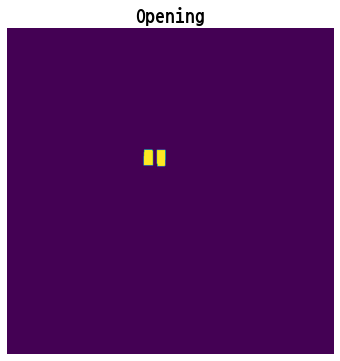

In [160]:
%matplotlib inline

img1 = read_img('진아1.jpg')[0]
img2 = read_img('진아2.jpg')[0]

stockchecker = stockChecker()
out = stockchecker.check(img1, img2)
bbox = out.pop()[0]

before_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
after_gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
_, diff = compare_ssim(before_gray, after_gray, full=True)
diff = np.where(diff < 0.6, 0, diff)
diff = (diff * 255).astype("uint8")



thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
kernel = np.ones((3,3),np.uint8)
# opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=5)
erosion = cv2.erode(thresh, kernel, iterations = 20)
dilation = cv2.dilate(erosion, kernel, iterations = 15)

imgs = [img1, diff, thresh, dilation, img2]
labels = ['before', 'SSIM', 'thresh', 'Opening', 'after']
# fig, axes = plt.subplots(1, 5, figsize=(20, 15))




# for i, (img, label) in enumerate(zip(imgs, labels)):
    # axes[i].imshow(img)
    # axes[i].axis('off')
    # axes[i].set_title(label, weight='semibold', size=20)
#     
    # plt.figure(figsize=(8, 6))
    # plt.imshow(img)
    # plt.axis('off')
    # plt.title(label, weight='semibold', size=20)
    # plt.show()

i = 3
img = imgs[i]
label = labels[i]
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis('off')
plt.title(label, weight='semibold', size=20)
plt.show()
# fig, axes = plt.subplots(1, 1, figsize=(8, 6))
# plot_without_label(img1, [bbox], axes)
# plt.title('Before', weight='semibold', size=20)
# plt.axis('off')
# plt.show()

# fig, axes = plt.subplots(1, 1, figsize=(8, 6))
# plot_without_label(img2, [bbox], axes)
# plt.title('After', weight='semibold', size=20)
# plt.axis('off')
# plt.show()

    

# Check Status

In [201]:
from modules.Human_detect import Humandetect
from modules.changeDetector import detectChange, get_diff
from modules.ramen_detect import Ramen
from modules.calcIou import CalIou, checkIou, CalIou2, checkIou2
from modules.classification import Classifier
from modules.outDetection import get_bbox_info, get_side_bbox, get_slope, check_status, check_status2
from modules.utils import *

before_img = read_img('진아1.jpg')[0]
after_img = read_img('진아2.jpg')[0]
before_bboxes = stockchecker.ramenDetector.ramen_detect(before_img)
after_bboxes = stockchecker.ramenDetector.ramen_detect(after_img) 
before_changed, before_scores, after_changed, after_scores = detectChange(before_img, after_img, before_bboxes, after_bboxes, threshold=50) 
iou_bboxes = CalIou2(before_changed, after_changed, threshold=0.4)

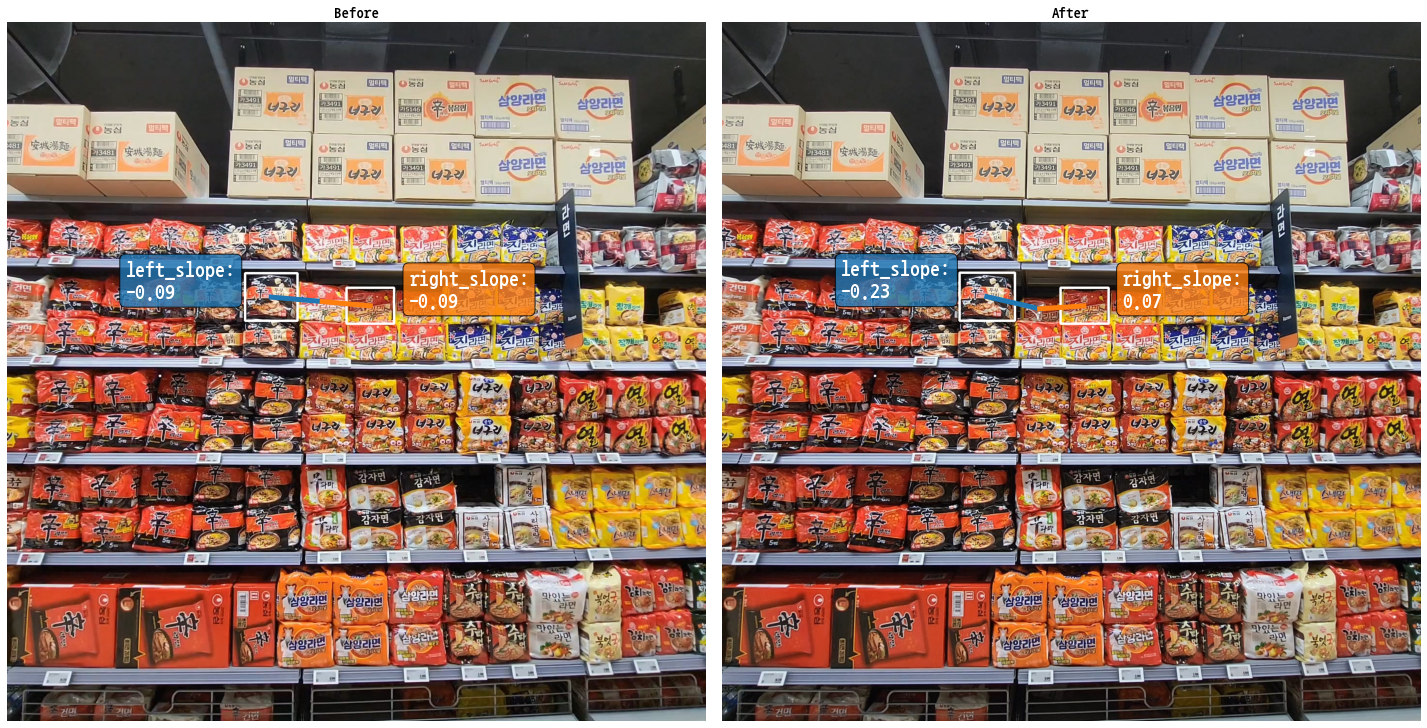

In [202]:
plot_slope(iou_bboxes)

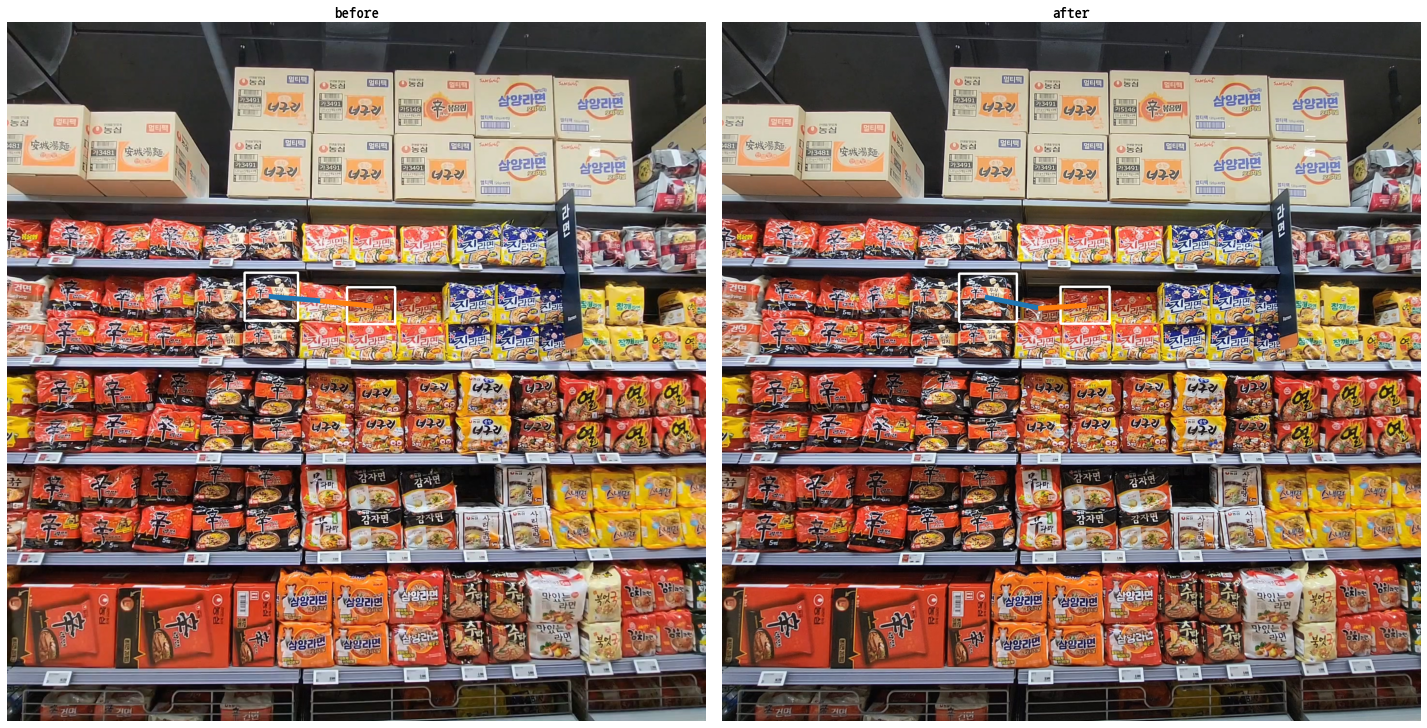

In [147]:
plot_slope(iou_bboxes)